# Modeling Notebook

This notebook will be focused on creating a model using the ticket data that has been prepared in the previous notebooks.  This includes some features created in regards to time deltas between certain milestones that may be useful in modeling.  Throughout EDA, the features of the data were not normally distributed, and generally highly skewed. In addition, no real linear relationships to the target were found.  Originally I thought a logistic regression model may be best, especially for interpretability, I will focus on creating a Random Forest classification model.  This will be more robust to some of the aforementioned data concerns uncovered in EDA, but also still provide some insight of specific ticket metrics/data via feature importances.

## Overview
The modeling process for this project was quite iterative.  I performed some intial modeling with the full dataset and was observing models that were performing < 1% over baseline accuracy, even after multiple attempts at grid searching for better hyperparameters.  When evaluating some of those attempts, it was also clear that the accuracy was mostly acheieved by predicting the majority class and not having much predictive power in the minority class.  At that point, additional feature engineering, feature selection, and class imbalance investigations ensued in an ad-hoc manner. 

In trying to capture the work that was done, you'll find various notebooks, sections, and commented out code blocks that speak to different parts of this process.  Here is an overview of the various resources:

* This notebook:
    * Final Modeling - post initial model, feature engineering, and feature selection attempts
        * 10 Features Modeling - modeling process using features selected after extended feature selection attempts from `05_feature_selection` notebook
        * SMOTE with 10 Feature Model - using SMOTE with the 10 feature model and examining differences
    * Appendix: Initial Modeling - represents some of the first modeling with the superset of features
        * This includes some comments and notes from the first stages of modeling   
* Supplement notebook:
    * Imbalanced Class Investigation - covers some of the ad-hoc manual sampling and SMOTE attempt

# Import Libraries

In [211]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             RocCurveDisplay)

from imblearn.over_sampling import SMOTE

# Read Data

Read the data file created from the data preparation stages of the project and check various aspects before modeling.

In [212]:
tickets = pd.read_pickle('../data/modeling_data.pkl')

In [213]:
tickets.head(3)

,sat_score,grp_stations,asign_stations,reopens,replies,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms,td_crtd_assnd,td_assnd_slvd,rply_rate,comm_rate
0,0,1,1,0,1,23.0,23,23,0,23,0,0.746100,2,7.0,15.0,0.043478,0.086957
1,0,1,1,0,1,45.0,45,45,0,44,0,0.526767,3,10.0,34.0,0.022222,0.066667
2,0,1,1,0,1,9.0,9,9,0,9,0,0.776250,2,7.0,2.0,0.111111,0.222222


In [214]:
tickets.shape

(13323, 17)

In [215]:
tickets.columns

Index(['sat_score', 'grp_stations', 'asign_stations', 'reopens', 'replies',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms',
       'td_crtd_assnd', 'td_assnd_slvd', 'rply_rate', 'comm_rate'],
      dtype='object')

In [216]:
tickets.dtypes

sat_score             int64
grp_stations          int64
asign_stations        int64
reopens               int64
replies               int64
reply_mins          float64
first_reso_mins       int64
full_reso_mins        int64
agt_wait_mins         int64
reqstr_wait_mins      int64
on_hold_mins          int64
sent_score          float64
num_comms             int64
td_crtd_assnd       float64
td_assnd_slvd       float64
rply_rate           float64
comm_rate           float64
dtype: object

In [217]:
tickets.isna().sum()[tickets.isna().sum() > 0]

Series([], dtype: int64)

In [218]:
tickets['sat_score'].value_counts()

1    11386
0     1937
Name: sat_score, dtype: int64

In [219]:
tickets['sat_score'].value_counts(normalize=True).mul(100).round(2)

1    85.46
0    14.54
Name: sat_score, dtype: float64

# Prepare Data

## Import Features from `05_feature_selection`

After some initial model performance issues, there was some ad-hoc feature selection and class imbalance investigation.  The algorithmic feature selection occurred in a separate notebook, but I did pickle different feature sets from that notebook so they could be imported here for for reference.  Time permitting, I'd like to work through modeling an evaluation on all these feature sets, but they are listed here in priority order for modeling:
1. `../data/select_10_feats.pkl` - the 10 features that had consensus between tree-based and RFE
2. `../data/k10_feats.pkl` - the 10 features that were identified by the univariate selection method
3. `../data/feats_common_eliminated.pkl` - feature list that excludes features that were eliminated by tree-based, rfe 10, and k10

**_NOTE: These feature lists do NOT include the target_**

In [220]:
with open('../data/select_10_feats.pkl', 'rb') as f:
    feats_10 = list(pickle.load(f))

## Train/Test Split

In [221]:
X = tickets[feats_10]
y = tickets['sat_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=415)

In [222]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10658, 10), (2665, 10), (10658,), (2665,))

Check stratification / class balance

In [223]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.854569
 0    0.145431
 Name: sat_score, dtype: float64,
 1    0.854784
 0    0.145216
 Name: sat_score, dtype: float64)

# Modeling

## Final Modeling: 10 Features

### Default Random Forest
Random Forest with all default parameter settings

In [224]:
rf = RandomForestClassifier()

In [225]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [226]:
print(
    f'CrossVal: {cross_val_score(rf, X_train, y_train).mean().round(4)}\n'
    f'Train Score: {rf.score(X_train, y_train).round(4)}\n'
    f'Test Score: {rf.score(X_test, y_test).round(4)}'
)

CrossVal: 0.8465
Train Score: 0.9999
Test Score: 0.8458


Default model is overfit, which tree models have a tendency to do, and Random Forests as they default to no limit on max_depth so nodes are expanded until all leaves are pure.  The test score is in line with the expectations from the cross val score, but slightly below baseline.

### Parameter GridSearch

In order to try and identify ideal hyperparameters, GridSearch will be used to search through a parameter grid.

In [227]:
# configure pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])


# feats_10 (will run if I have time; not done yet)
rf_params = {
    'rf__n_estimators': np.arange(210, 241, 5),
    'rf__criterion' : ["gini", "entropy"],
    'rf__max_depth': np.arange(8, 15, 1),
    'rf__min_samples_leaf': np.arange(4, 10),
    'rf__bootstrap': [True],
    'rf__warm_start': [True, False],
    'rf__max_features': np.arange(2, 5)
}

# param grid for feats_10 (42m)
# rf_params = {
#     'rf__n_estimators': np.arange(100, 250, 25),
#     'rf__criterion' : ["gini", "entropy"],
#     'rf__max_depth': np.arange(10, 50, 10),
#     'rf__min_samples_leaf': np.arange(1, 6),
#     'rf__bootstrap': [True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': np.arange(3, 6)
# }

# new param grid for feats_10 broad search (too broad; had to bail after 23h 18m)
# Fitting 5 folds for each of 36000 candidates, totalling 180000 fits
# rf_params = {
#     'rf__n_estimators': np.arange(50, 300, 25),
#     'rf__criterion' : ["gini", "entropy"],
#     'rf__max_depth': np.arange(10, 100, 10),
#     'rf__min_samples_leaf': np.arange(1, 11),
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': np.arange(3, 8)
# }

In [228]:
# commenting out so notebook can be run
# gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, verbose=1)
# gs.fit(X_train, y_train)
# gs.best_params_

# feats_10 #1 42m
# Fitting 5 folds for each of 1440 candidates, totalling 7200 fits

# {'rf__bootstrap': True,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 10,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 200,
#  'rf__warm_start': True}

#### Save Model

Create a classifier with the parameters found and save it for reference and re-use.

In [229]:
rf_feats_10 = RandomForestClassifier(bootstrap=True,
                                     criterion='gini',
                                     max_depth=10,
                                     max_features=3,
                                     min_samples_leaf=5,
                                     n_estimators=200,
                                     warm_start=True)

In [230]:
with open('../models/rf_feats_10.pkl', 'wb') as f:
    pickle.dump(rf_feats_10, f)

### Evaluation

In this section, various aspects of the model performance will be examined.

#### Model Score

In [231]:
# recall baseline
y_test.value_counts(normalize=True)

1    0.854784
0    0.145216
Name: sat_score, dtype: float64

Now that the model has been saved above, estimator is now `rf_feats_10`, fit and score:

In [232]:
rf_feats_10.fit(X_train, y_train)

print(
f'CrossVal: {cross_val_score(rf_feats_10, X_train, y_train).mean().round(4)}\n'
f'Train Score: {rf_feats_10.score(X_train, y_train).round(4)}\n'
f'Test Score: {rf_feats_10.score(X_test, y_test).round(4)}'
)

CrossVal: 0.8552
Train Score: 0.8602
Test Score: 0.8544


At first glance, this looks to be a model that isn't overfit and has reasonable scores, given the cross validation score, however, the test score is reporting accuracy very close to the baseline of 85.47% so this is very minimal improvement.

#### Classification Report and Confusion Matrix

In [233]:
print(
    classification_report(y_test,
                          rf_feats_10.predict(X_test))
)

              precision    recall  f1-score   support

           0       0.40      0.01      0.01       387
           1       0.86      1.00      0.92      2278

    accuracy                           0.85      2665
   macro avg       0.63      0.50      0.47      2665
weighted avg       0.79      0.85      0.79      2665



This is very similar to what was observed in the initial model, especially looking at how the recall and f1-scores are very far apart from each other.  
* Recall is so low since there were only 2 predicted minority class samples out of 387.  
* The precision score, especially for the minority class is misleading since .50 does not seem that bad, but it's because it only predicted 4 total "0" values and 2 were correct.  

Overall, this model is not predicting the minority class samples very well at all.

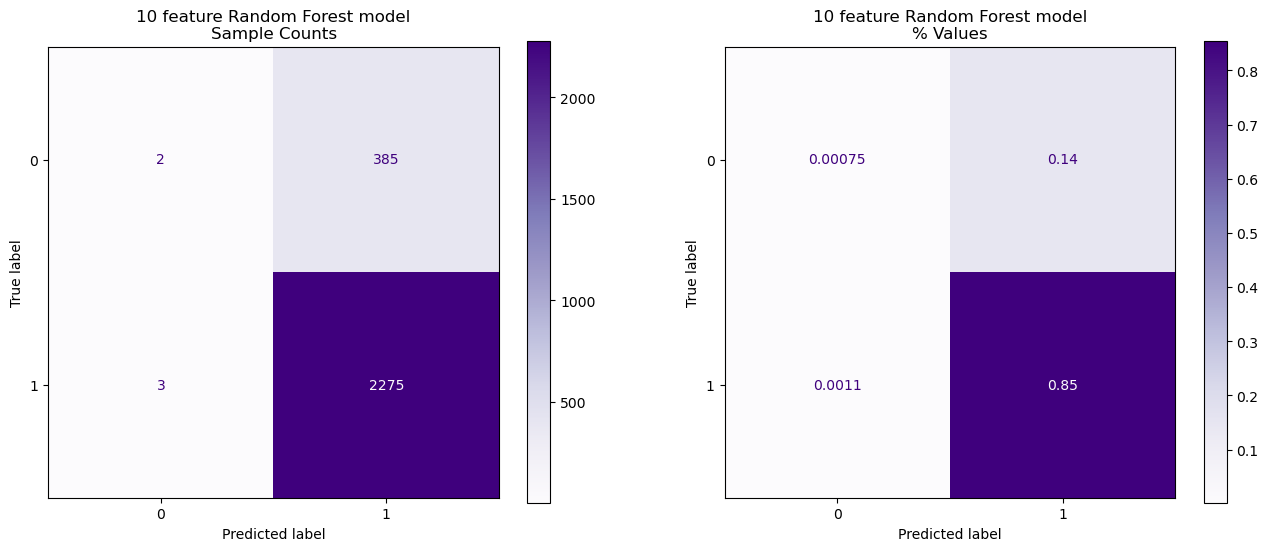

In [234]:
# feats_10 #1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ConfusionMatrixDisplay.from_estimator(rf_feats_10, 
                                      X_test, 
                                      y_test,
                                      cmap='Purples',
                                      ax=ax1)
ax1.set_title('10 feature Random Forest model\nSample Counts')

ConfusionMatrixDisplay.from_estimator(rf_feats_10, 
                                      X_test, 
                                      y_test,
                                      normalize='all',
                                      cmap='Purples',
                                      ax=ax2)
ax2.set_title('10 feature Random Forest model\n% Values');

Here we can see that the model is predicting the majority class in most cases, ~99% of the time.  This is causing many false positives.  Also, very small percentages of false negative and true negative values.  This is indicating that the model still, even after the algorithmic feature selection, isn't separating the classes very well.

#### Probabilities

To continue to understand more aspects about these results, we'll predict probabilities and examine some of the scores to see how that supports what we're seeing above in the classification report and the confusion matrix.

In [235]:
# create dataframe from predicted probabilities from the esimator
probs = pd.DataFrame(rf_feats_10.predict_proba(X_test), 
                     columns=rf_feats_10.classes_)

In [236]:
# add a column for the true y_test values
probs['true'] = y_test.values

In [237]:
# I'll look at observations were the true value was 0 and see what the 
# probabilities look like.  These are the samples with the highest probability
# of being "0"
(
    probs
    .query('true == 0')
    .sort_values(by=0 , ascending=False)
    .head(10)
)

,0,1,true
1317,0.610982,0.389018,0
1703,0.549208,0.450792,0
986,0.495786,0.504214,0
29,0.478812,0.521188,0
1212,0.463047,0.536953,0
493,0.460148,0.539852,0
1667,0.438273,0.561727,0
144,0.415022,0.584978,0
2616,0.408643,0.591357,0
913,0.403861,0.596139,0


When looking at this, it supports the conclusions in the previous evaluation steps that the model is having difficulties predicting the minority class.  This table shows that of the true "0" values, only 2 had more than 50% probability.

In [238]:
(
    probs
    .sort_values(by=0, ascending=False)
    .head()
)

,0,1,true
1317,0.610982,0.389018,0
1742,0.554965,0.445035,1
1703,0.549208,0.450792,0
1836,0.537680,0.462320,1
1489,0.505332,0.494668,1


Here I'm just looking at the high highest probabilities for the minority class--the higest is around 61% and by the fifth record, it's already around 50%.

#### ROC 

We'll plot the ROC AUC for the selected Random Forest model.

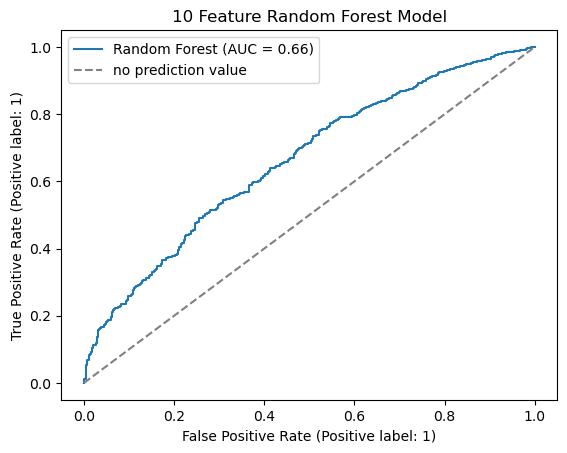

In [239]:
# From classification lesson
# Create an ax object
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rf_feats_10, X_test, y_test, 
                               ax=ax, name='Random Forest')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')

# Necessary to label the baseline
plt.title('10 Feature Random Forest Model')
plt.legend();

This ROC AUC score is representing some of the issues that became apparent in the classification report that the model is having issues distinguishing between the two classes.  In this chart, you are looking at the area above the dotted line, which represents if the model had no prediction value, which would represent an AUC score of .5, and under the curved blue line.  The more area under the curve (AUC) the better the model is at discriminating between classes.

#### Feature Importances

In [240]:
# extract the feature importance values from the model
pd.DataFrame(
    rf_feats_10.feature_importances_,
    X.columns
).reset_index().sort_values(by=0, ascending=False)

,index,0
5,sent_score,0.118327
9,comm_rate,0.115594
8,rply_rate,0.105802
2,full_reso_mins,0.100955
1,first_reso_mins,0.097286
0,reply_mins,0.096803
7,td_assnd_slvd,0.095460
4,reqstr_wait_mins,0.092733
6,td_crtd_assnd,0.091874
3,agt_wait_mins,0.085166


These feature importance values, represent the Gini importance and as they are listed, the higher the value the more important the feature is. [(source)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_)

### SMOTE: 10 Features

Although the model with the selected features is still not performing well, there is higher confidence in the features selected due to the work done in the feature selection notebook.  Given that, I feel like it would be worthwhile to go through SMOTE again with this feature set and examine the results.

#### Import Model

Import the model that was saved earlier so it can be trained with this new data.

In [241]:
with open('../models/rf_feats_10.pkl', 'rb') as f:
    rf_feats_10 = pickle.load(f)

#### Scale Data
SMOTE uses kNN type distances to understand and then synthesize the data, so the data will need to be scaled.

In [242]:
# scale X data, using the existing train and test data from 
# feats_10 feature space
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

#### Instantiate and Resample

In [243]:
# SMOTE
sm = SMOTE(random_state=415)

X_train_smote, y_train_smote = sm.fit_resample(X_train_ss, y_train)

#### Check Shape and Class Balance

In [244]:
# check shape
X_train_smote.shape, y_train_smote.shape

((18216, 10), (18216,))

In [245]:
X_train_ss.shape

(10658, 10)

After performing the SMOTE resampling, almost 8,000 rows were added to the training data.

In [246]:
# check value counts post-SMOTE
y_train_smote.value_counts(normalize=True)

0    0.5
1    0.5
Name: sat_score, dtype: float64

Now the classes are balanced.

#### Model on Resampled Data

In [247]:
# fit data to our model
rf_feats_10.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=10, max_features=3, min_samples_leaf=5,
                       n_estimators=200, warm_start=True)

#### Evaluate

In [248]:
print(
f'CrossVal: '
f'{cross_val_score(rf_feats_10, X_train_smote, y_train_smote).mean().round(4)}\n'
f'Train Score: '
f'{rf_feats_10.score(X_train_smote, y_train_smote).round(4)}\n'
f'Test Score: '
f'{rf_feats_10.score(X_test_ss, y_test).round(4)}\n'
)

CrossVal: 0.7253
Train Score: 0.8127
Test Score: 0.6886



In the pre-SMOTE model, we saw a bit more balance between the scores, but the real interest here is in how the classification results came out.

In [249]:
print(classification_report(y_test, 
                            rf_feats_10.predict(X_test_ss)
                           ))

              precision    recall  f1-score   support

           0       0.21      0.42      0.28       387
           1       0.88      0.73      0.80      2278

    accuracy                           0.69      2665
   macro avg       0.55      0.58      0.54      2665
weighted avg       0.78      0.69      0.73      2665



After fitting the model with the synthetic data from the SMOTE approach certainly changed how the model performed on the test set.  We see increased recall and f1-score for the minorty class at the cost of a drop in both those areas for the majority class, and because of that, a drop in overall accuracy.

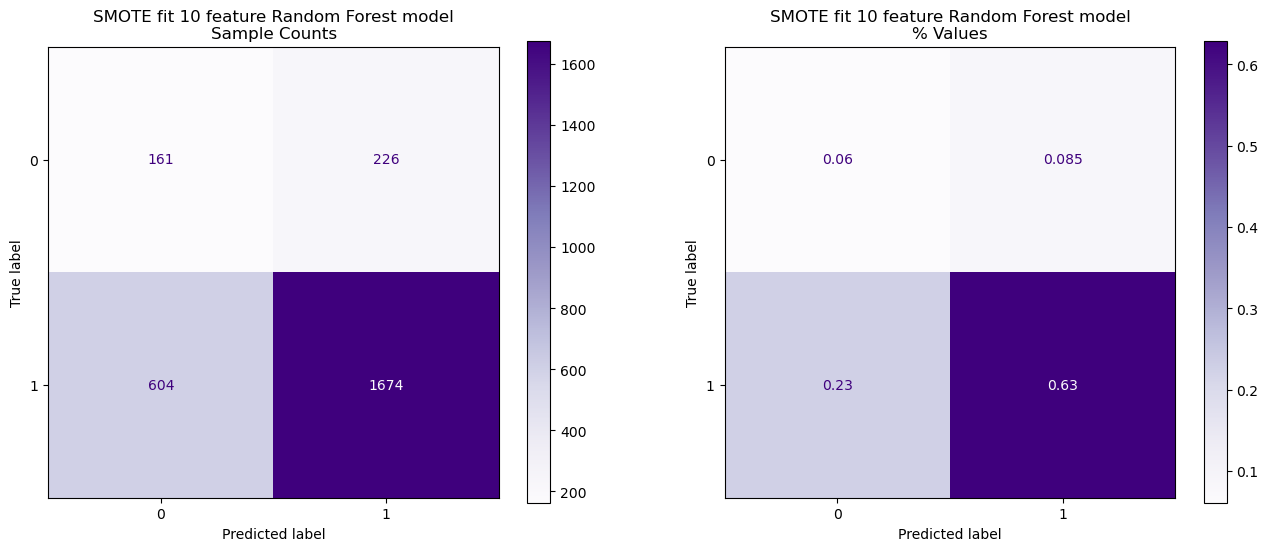

In [250]:
# attempt after smote
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ConfusionMatrixDisplay.from_estimator(rf_feats_10, 
                                      X_test_ss, 
                                      y_test,
                                      cmap='Purples',
                                      ax=ax1)
ax1.set_title('SMOTE fit 10 feature Random Forest model\nSample Counts')

ConfusionMatrixDisplay.from_estimator(rf_feats_10, 
                                      X_test_ss, 
                                      y_test,
                                      normalize='all',
                                      cmap='Purples',
                                      ax=ax2)
ax2.set_title('SMOTE fit 10 feature Random Forest model\n% Values');

What becomes more clear when looking at the confusion matrix from the SMOTE trained model is that there were many more minority class predictions, but this caused a jump in the false negatives, whereas the previous model had more false positives, since it was almost always just predicting the majority class.  So although fitting with data transformed by SMOTE increased the model's ability to predict the minority class, it still isn't achieving high performance.  I believe this indicates that only part of the issue with model performance is related to the class imbalance, but the larger issue is with the underlying data.

#### ROC 

We'll plot the ROC AUC for the selected Random Forest model.

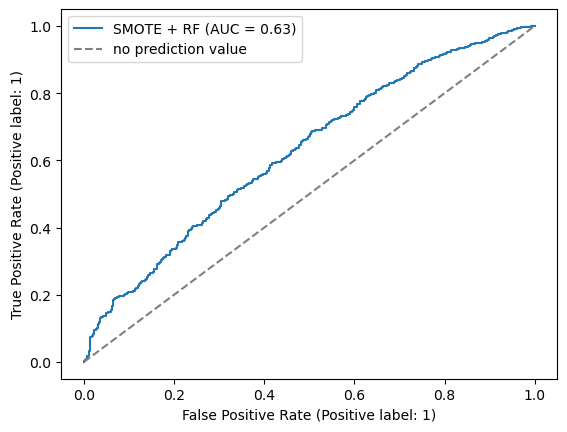

In [251]:
# from a classification lesson
# Create an ax object
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rf_feats_10, 
                               X_test_ss, 
                               y_test, 
                               ax=ax, 
                               name='SMOTE + RF')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')

# Necessary to label the baseline
plt.legend();

This is very close to the first ROC AUC we saw, indicating that model, as we've seen in other metrics, has issues differentiating between classes for predictions.

#### Feature Importances

In [252]:
# extract the feature importance values from the model
pd.DataFrame(
    rf_feats_10.feature_importances_,
    X.columns
).reset_index().sort_values(by=0, ascending=False)

,index,0
8,rply_rate,0.125533
9,comm_rate,0.120100
5,sent_score,0.114790
7,td_assnd_slvd,0.102277
2,full_reso_mins,0.099119
3,agt_wait_mins,0.098357
0,reply_mins,0.087903
1,first_reso_mins,0.086091
6,td_crtd_assnd,0.083776
4,reqstr_wait_mins,0.082053


The previous model's feature importances, in order were:
1. `sent_score 	0.118900`
2. `comm_rate 	0.109572`
3. `rply_rate 	0.104666`
4. `full_reso_mins 	0.103369`
5. `reply_mins 	0.098494`

Three of the top five in these lists are the same, but in a slight different order.  Although the model isn't performing well and providing a lot of confidence in these values, since there were some common elements between these two lists, that is what I would choose to focus on from a business perspective.

# Modeling Conclusions and Next Steps

When looking at the classification report, some of the scores, like recall were a bit better with SMOTE.  Before we were seeing recall scores in the high .9x range for the majority class and .0x range for the minority class.  This improvement over the previous model that was created wasn't major, but did provide some insight, especially since this was after trying various algorithmic feature selection techniques. Class imbalance is part of the issue, but there is more likely an issue with the underlying data, such as:
* Features don't explain target very well
* Not enough meaningful features are present in the data
* Too much variation in the data due to business process issues

With that in mind, this model doesn't provide a lot of confidence in these results, but the areas that can be identified at this point as important to customer satisfaction ratings are:
* Ticket activity (comments and replies frequency)
* The sentiment of the comments in the ticket (sentiment score)
* Full Resolution time of the ticket

Overall, it would be ideal to build more confidence in the model, and by extension which features are the most important to focus on as a business to improve customer satisfaction going forward.  Some possible next steps to acheive this:
* Try modeling with other feature combinations identified from the feature selection process
* Research [permutation importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) for understanding the features of the model in perhaps a more meaningful way

# ------------------------------------

# Appendix: Initial Modeling

_**Note: This was from first my first attempt at modeling and included for reference and background information.**_

## Configure X, y, Train/Test Split

In [253]:
# adjusting this code slightly to more closely represent the initial modeling
# when the rate/frequency features were not created
X = tickets.drop(columns=['sat_score', 'rply_rate', 'comm_rate'])
y = tickets['sat_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=415)

In [254]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10658, 14), (2665, 14), (10658,), (2665,))

Check stratification / class balance

In [255]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.854569
 0    0.145431
 Name: sat_score, dtype: float64,
 1    0.854784
 0    0.145216
 Name: sat_score, dtype: float64)

## Default Random Forest
Random Forest with all default parameter settings

In [256]:
rf = RandomForestClassifier()

In [257]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [258]:
cross_val_score(rf, X_train, y_train).mean().round(4)

0.8458

In [259]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9999061737661851, 0.8457786116322702)

Default model is overfit, which tree models have a tendency to do.  The test score is in line with the expectations from the cross val score, but this is actually below baseline.

## Parameter GridSearch

In order to identify ideal hyperparameters, GridSearch will be used in various degrees.  First, a broad range of values will be used to identify parameter values that are ideal at that level, and then once those are identified some fine-tuning around those broad parameters to see if additional performance can be obtained.

In [260]:
# configure pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# Attempt 3 fine tune settings from attempt 2
# leave some params like bootstrap and warm start
# narrow range of others
rf_params = {
    'rf__n_estimators': np.arange(15, 25, 1),
    'rf__criterion' : ["gini", "entropy", "log_loss"],
    'rf__max_depth': np.arange(10, 20, 1),
    'rf__min_samples_leaf': np.arange(5, 11),
    'rf__bootstrap': [True],
    'rf__warm_start': [True],
    'rf__max_features': np.arange(3, 9)
}


# Univariate k=10 (removed log-loss)
# Attempt 1 7h 43m gridsearch
# Attempt 2 after feature engineering 9h 27m
# rf_params = {
#     'rf__n_estimators': np.arange(25, 300, 50),
#     'rf__criterion' : ["gini", "entropy"],
#     'rf__max_depth': np.arange(5, 100, 10),
#     'rf__min_samples_leaf': np.arange(3, 11),
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': np.arange(1, 6)
# }

In [261]:
# commenting out so notebook can be run
# gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, verbose=1)
# gs.fit(X_train, y_train)
# gs.best_params_

# univariate k=10  6h 14m 
# Fitting 5 folds for each of 19200 candidates, totalling 96000 fits
# {'rf__bootstrap': True,
#  'rf__criterion': 'entropy',
#  'rf__max_depth': 65,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 10,
#  'rf__n_estimators': 25,
#  'rf__warm_start': True}

# attempt 3 after feature engineering 9h 27m (0.8744604991555639, 0.8559099437148218)
# THIS BECAME THE MODEL REFERENCED AS rf_nine (used in feature selection)
# Fitting 5 folds for each of 28800 candidates, totalling 144000 fits
# {'rf__bootstrap': True,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 95,
#  'rf__max_features': 4,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 175,
#  'rf__warm_start': True}

# attempt 2 (0.8645149183711766, 0.8551594746716698)
# {'rf__bootstrap': True,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 10,
#  'rf__max_features': 6,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 16,
#  'rf__warm_start': True}

# attempt 1 (0.8655470069431414, 0.8555347091932458) 
# {'rf__bootstrap': True,
#  'rf__criterion': 'entropy',
#  'rf__max_depth': 15,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 6,
#  'rf__n_estimators': 25,
#  'rf__warm_start': True}

## Evaluation

Import model `rf_nine` (derived from the attempt 3 grid search above) to re-create the data below.  It got its name from the 9+ hour gridsearch that was carried out.

In [262]:
# importing so results can be recreated without the need to run the 
# gridsearch

with open('../models/rf_nine.pkl', 'rb') as f:
    rf_nine = pickle.load(f)

Fit the imported model

In [263]:
rf_nine.fit(X_train, y_train)

RandomForestClassifier(max_depth=95, max_features=4, min_samples_leaf=5,
                       n_estimators=175, warm_start=True)

In [264]:
print(f'CrossVal: {cross_val_score(rf_nine, X_train, y_train).mean().round(4)}')
print(f'Train Score: {rf_nine.score(X_train, y_train).round(4)}')
print(f'Test Score: {rf_nine.score(X_test, y_test).round(4)}')

CrossVal: 0.8546
Train Score: 0.8736
Test Score: 0.8559


In [265]:
print(classification_report(y_test, rf_nine.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.02      0.04       387
           1       0.86      1.00      0.92      2278

    accuracy                           0.86      2665
   macro avg       0.75      0.51      0.48      2665
weighted avg       0.82      0.86      0.79      2665



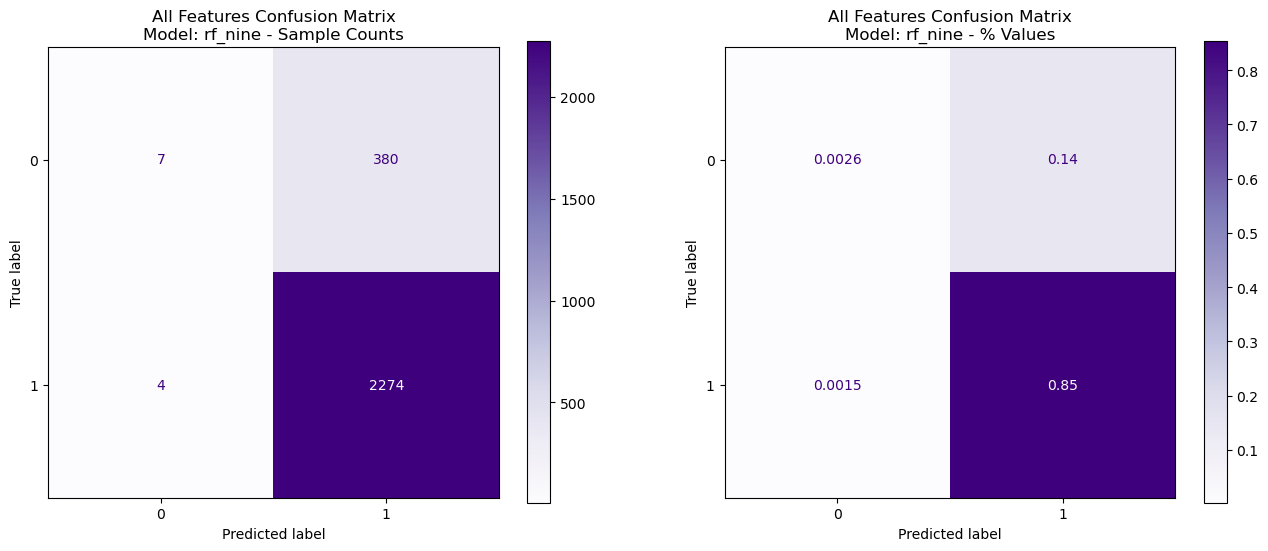

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ConfusionMatrixDisplay.from_estimator(rf_nine, 
                                      X_test, 
                                      y_test,
                                      cmap='Purples',
                                      ax=ax1)
ax1.set_title('All Features Confusion Matrix\nModel: rf_nine - Sample Counts')

ConfusionMatrixDisplay.from_estimator(rf_nine, 
                                      X_test, 
                                      y_test,
                                      normalize='all',
                                      cmap='Purples',
                                      ax=ax2)
ax2.set_title('All Features Confusion Matrix\nModel: rf_nine - % Values');

After a pretty large gridsearch, the scores from cross validation and the accuracy scores from the model would not indicate that the model is overfit, but overall, the improvement over baseline is minimal. Baseline (majority class) is 85.47% and this modely accuracy on the test score is 85.4%, so that is basically the baseline.  

In addition, when you look at the recall values, it is very low in the minority class which means the model is not good at actually guessing negative values.

We'll plot the ROC AUC for the selected Random Forest model.

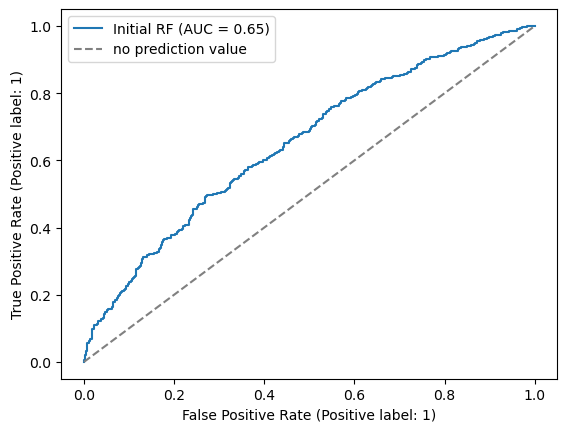

In [267]:
# Create an ax object
ax = plt.gca()

# Use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rf_nine, 
                               X_test, 
                               y_test, 
                               ax=ax, 
                               name='Initial RF')

# Add 'worst case scenario' line
plt.plot([0,1], [0,1], label='no prediction value', 
         linestyle='--', color='gray')

# Necessary to label the baseline
plt.legend();

This ROC AUC score is representing some of the issues that became apparent in the classification report that the model is having issues distinguishing between the two classes.  In this chart, you are looking at the area above the dotted line, which represents if the model had no prediction value, which would represent an AUC score of .5, and under the curved blue line.  The more area under the curve (AUC) the better the model is at discriminating between classes.

In [268]:
# univariate k=10 after 9 hour grid search
print(classification_report(y_test, 
                            rf_nine.predict(X_test), 
                           ))

#               precision    recall  f1-score   support

#            0       0.50      0.00      0.01       387
#            1       0.86      1.00      0.92      2278

#     accuracy                           0.85      2665
#    macro avg       0.68      0.50      0.46      2665
# weighted avg       0.80      0.85      0.79      2665

              precision    recall  f1-score   support

           0       0.64      0.02      0.04       387
           1       0.86      1.00      0.92      2278

    accuracy                           0.86      2665
   macro avg       0.75      0.51      0.48      2665
weighted avg       0.82      0.86      0.79      2665



In [269]:
# pull probability data from the imported model
# probs = pd.DataFrame(gs.best_estimator_.predict_proba(X_test), columns=gs.classes_)

In [270]:
# probs.sort_values(by=0, ascending=False).head()

## Export Model

In [271]:
# # parameters found from 9 hour grid search 
# rf_nine = RandomForestClassifier(bootstrap=True,
#                                  criterion='gini',
#                                  max_depth=95,
#                                  max_features=4,
#                                  min_samples_leaf=5,
#                                  n_estimators=175,
#                                  warm_start=True)

In [272]:
# # export rf_nine model (initial model from 9 hour gridsearch)
# with open('../models/rf_nine.pkl', 'wb') as f:
#     pickle.dump(rf_nine, f)

## Ad-hoc Scoring

Scoring reports from ad-hoc feature selection attempts with the `rf_nine` model

In [273]:
# rf_nine.score(X_train, y_train), rf_nine.score(X_test, y_test)

# before dropping on_hold_mins: (0.874085194220304, 0.8536585365853658)
# after dropping on_hold_mins: (0.8757740664289735, 0.8540337711069418)
# k=4 feats only:     (0.8737098892850441, 0.8544090056285178)

## Ad-hoc Classification Reports
Classification reports from various attempts at different feature sets with the `rf_nine` model

In [274]:
# univariate k=4 only

# train, test scores: (0.8737098892850441, 0.8544090056285178)

# classification report
#               precision    recall  f1-score   support

#            0       0.47      0.02      0.04       387
#            1       0.86      1.00      0.92      2278

#     accuracy                           0.85      2665
#    macro avg       0.66      0.51      0.48      2665
# weighted avg       0.80      0.85      0.79      2665

In [275]:
# after dropping on_hold_mins

# train, test scores: (0.8757740664289735, 0.8540337711069418)

# classification report
#               precision    recall  f1-score   support

#            0       0.38      0.01      0.02       387
#            1       0.86      1.00      0.92      2278

#     accuracy                           0.85      2665
#    macro avg       0.62      0.50      0.47      2665
# weighted avg       0.79      0.85      0.79      2665

In [276]:
# before dropping on_hold_mins

# train, test scores: (0.874085194220304, 0.8536585365853658)

# classification report
#               precision    recall  f1-score   support

#            0       0.36      0.01      0.02       387
#            1       0.86      1.00      0.92      2278

#     accuracy                           0.85      2665
#    macro avg       0.61      0.50      0.47      2665
# weighted avg       0.78      0.85      0.79      2665

## Ad-hoc Feature Importances
Attempts at collecting feature importances to use to do some early feature selection

In [277]:
# pd.DataFrame(
#     gs.best_estimator_.named_steps.rf.feature_importances_,
#     X.columns
# ).reset_index().sort_values(by=0, ascending=False)

# sent_score 	0.115195
# comm_rate 	0.097254
# td_crtd_assnd 	0.094701
# reqstr_wait_mins 	0.092093
# reply_mins 	0.091864
# rply_rate 	0.089124
# full_reso_mins 	0.087845
# first_reso_mins 	0.086339
# td_assnd_slvd 	0.083209
# agt_wait_mins 	0.077130
# num_comms 	0.038738
# replies 	0.019137
# reopens 	0.009809
# grp_stations 	0.007971
# asign_stations 	0.005473
# on_hold_mins 	0.004119

In [278]:
# pd.DataFrame(
#     gs.best_estimator_.named_steps.rf.feature_importances_,
#     ctx.get_feature_names_out()
# ).reset_index()

# sub_len 	0.098831
# desc_len 	0.096306
# reply_mins 	0.091590
# full_reso_mins 	0.088125
# sent_score 	0.082362
# td_crtd_slvd 	0.079445
# td_assnd_slvd 	0.078217
# reqstr_wait_mins 	0.076315
# td_crtd_assnd 	0.075706
# first_reso_mins 	0.066895
# agt_wait_mins 	0.066812
# replies 	0.037240
# reopens 	0.013764
# channel_email 	0.011843
# grp_stations 	0.011614
# channel_web 	0.010907
# asign_stations 	0.007504
# on_hold_mins 	0.006524
# channel_help_center 	0.000000
# channel_api 	0.000000

Since the model, with the various grid searches and parameters tried, isn't performing very well relative to baseline, I'm going to explore some techniques to try and address this.  I'll try undersampling the majority class and will also try SMOTE to see if either of those approaches may help with this models performance.  I'm primarily interested in these since we have plenty of representation of the majority class, but are lacking some representation of the minority class.  If both of these approaches do not yield better results, I'll explore any additional treatment of the data, such as limiting outliers, or even exploring if there are other features I might be able to get from Zendesk.